# Radiative transfer

To test whether the radiative transfer calculation is working correctly, I will examine a model with erroneous intensity calculations (with some sightlines being $~10^{40}K$). Below we can see how the whole sky map can be narrowed to just a few erroneous sightlines.

There is now functionality when evaluating the sightlines to save the intermediate arrays in numpy files (`I.npy`, `e.npy`, `de.npy`, `k.npy`, `dk.npy`, `a.npy`, and `b.npy`, corresponding to $I_\nu$, $\epsilon_\nu$, $\Delta \epsilon_\nu$, $\kappa_\nu$, $\Delta \kappa_\nu$, $a_\nu$, and $b_\nu$, respectively) if an erroneous intensity is calculated. This allows us to load and work with the data in this notebook.

Currently an intensity is flagged as erroneous if $I_\nu > 10**{10} K$ or $I_\nu < 0 K$.

## Theory

In order to test the correct calculation of radiative transfer, the theory must first be covered. The radiative transfer (RT) equation,

(1)$$
dI_\nu = - I_\nu \kappa_\nu ds + \epsilon_\nu ds
$$

must be integrated to calculate the observed intensity. Simple applications of RT assume constant $\epsilon_\nu$ and $\kappa_\nu$ between voxels to obtain the observed intensity. The benefit of `kosmatau3d` is the improved calculation of the RT equation. Here the emissivity and absorption terms, $\epsilon_\nu$ and $\kappa_\nu$, are still used, but the first-order linear terms, $\Delta\epsilon_\nu = \frac{\epsilon_\nu}{\Delta s}$ and $\Delta\kappa_\nu = \frac{\kappa_\nu}{\Delta s}$, also appear. Here $\Delta s$ is the width of each voxel. This leads to,

(2)$$
I_\nu = e^{-\kappa_\nu \Delta s - \frac{1}{2} \Delta \kappa_\nu \Delta s^2} \left[ \int_0^{\Delta s}\left( \epsilon_\nu + \Delta \epsilon_\nu s' \right) e^{\kappa_\nu s' + \frac{1}{2} \Delta \kappa_\nu s'^2} ds' + I_{bg} \right],
$$

and allows us to define specific cases for the way we integrate the RT equation:

 - *Basic*: $\Delta\kappa = 0$ and $| \kappa \Delta s | < 10^{-10}$
 - *Simple*: $\kappa > 10^3 \Delta \kappa \Delta s$
 - *Complex*: otherwise
   - *method 1*: $\Delta \kappa > 0$
   - *method 2*: $\Delta \kappa < 0$
   
The complex methods of calculating the RT equation are the most accurate, and should be used by default. The other methods are simplifications that can be made. The *Basic* case occurs when there is (mostly) no absorption. Since $\kappa_\nu = 0$ and $\Delta\kappa_\nu = 0$, the RT equation becomes, 

$$
\int_0^{I_\nu} dI_\nu = \int_0^{\Delta s} \left( \epsilon_\nu + \Delta\epsilon_\nu s' \right) ds', \\
I_\nu = \epsilon_\nu \Delta s + \frac{1}{2} \Delta\epsilon_\nu \left( \Delta s \right)^2 + I_{\nu,0}.
$$

The *Simple* case occurs when there is constant absorption, so $\Delta\kappa_\nu = 0$ and $\kappa_\nu \neq 0$. This has a more-complex equation:

$$
\int_0^{I_\nu} dI_\nu = e^{-\kappa_\nu \Delta s} \left( \int_0^{\Delta s} (\epsilon_\nu + \Delta \epsilon_\nu s') e^{\kappa_\nu s'} ds' + I_0 \right), \\
I_\nu = \left( \frac{\epsilon_\nu \kappa_\nu + \Delta\epsilon_\nu (\kappa_\nu \Delta s - 1)}{\kappa_\nu^2} \right) - e^{-\kappa_\nu \Delta s} \left( \frac{\epsilon_\nu \kappa_\nu - \Delta\epsilon_\nu}{\kappa_\nu^2} \right) + e^{-\kappa_\nu \Delta s} I_{\nu,0}.
$$

Finally, the *Complex* integration is the full unsimplified integration of the RT equation:

$$
I_\nu = \tilde{I_\nu} + I_{bg}, \\
\tilde{I_\nu} = \frac{\Delta \epsilon_\nu}{\Delta \kappa_\nu} \left[ 1 - e^{-\kappa_\nu \Delta s - \frac{1}{2} \Delta \kappa_\nu \Delta s^2} \right] - \frac{\epsilon_\nu \Delta \kappa_\nu - \kappa_\nu \Delta \epsilon_\nu}{\sqrt{\Delta \kappa_\nu}^3} \sqrt{\frac{\pi}{2}} e^{-\frac{(\kappa_\nu + \Delta \kappa_\nu \Delta s)^2}{2 \Delta \kappa_\nu}} \left[ \mathrm{erfi} \left( \frac{\kappa_\nu}{\sqrt{2 \Delta \kappa_\nu}} \right) - \mathrm{erfi} \left( \frac{\kappa_\nu + \Delta \kappa_\nu \Delta s}{\sqrt{2 \Delta \kappa_\nu}} \right) \right].
$$

The only distinction made is if $\Delta\kappa \lessgtr 0$.

$$
I_\nu = \frac{\Delta\epsilon_\nu}{\Delta\kappa_\nu} \left( 1 - e^{-\kappa_\nu \Delta s - \frac{1}{2} \Delta\kappa_\nu (\Delta s)^2} \right) - \frac{\epsilon_\nu \Delta\kappa_\nu - \kappa_\nu \Delta\epsilon_\nu}{\Delta\kappa_\nu} \sqrt{\frac{\pi}{2|\Delta\kappa_\nu|}} \left( e^{a_\nu^2 - b_\nu^2}\tilde{E}(a_\nu) - \tilde{E}(b_\nu) \right) + I_{\nu,0} e^{-\kappa_\nu \Delta s - \frac{1}{2} \Delta\kappa_\nu (\Delta s)^2}
$$

Here $a_\nu=\frac{\kappa_\nu}{\sqrt{2\Delta\kappa_\nu}}$ and $b_\nu=\frac{\kappa_\nu + \Delta\kappa_\nu \Delta s}{\sqrt{2 \Delta\kappa_\nu}}$, while $\tilde{E}$ is an approximation of the imaginary error function. The distinction we make is how we treat the error function if $a,b$ are real or imaginary values. This is what I believe to be the primary issue in the calculation of the RT equation: the handling of complex values. I need to perform the integration to properly understand how to treat the complex numbers, namely in the exponential function of $a$ and $b$. As seen below, this might be causing the erroneous negative observed intensities.

## Calculation

With the radiative transfer method focused on the offending sightlines, we can obtain these values used in the RT equation. Now it is simply a matter of re-evaluating manually to compare the results (and find any relevant error). Since our model of interest has voxels with size $s=400pc$, we have $\Delta s = s [cm]$.

In [34]:
import numpy as np

ds = np.load(r'ds_dust.npy')
test_intensity = np.load(r'I_dust.npy')
test_epsilon = np.load(r'e_dust.npy')
test_depsilon = np.load(r'de_dust.npy')
test_kappa = np.load(r'k_dust.npy')
test_dkappa = np.load(r'dk_dust.npy')
test_a_old = np.load(r'a_dust.npy')
test_b_old = np.load(r'b_dust.npy')
test_a = test_kappa[:-1]/np.sqrt(2*np.abs(test_dkappa))
test_b = (test_kappa[:-1]+test_dkappa*ds)/np.sqrt(2*np.abs(test_dkappa))

In [18]:
test_a_old.shape, test_kappa.shape, (test_kappa[:-1]/np.sqrt(np.abs(test_dkappa))).shape

((22, 1), (23, 1), (22, 1))

In [20]:
test_a.shape

(22, 1)

In [2]:
from scipy import interpolate
from scipy.special import erfi, erfc

# GRIDPATH = r'c:\users\cyani\KOSMA-tau^3\kosmatau3d\grid'
GRIDPATH = '/home/yanitski/kosmatau3d/kosmatau3d/grid'

def eTildeRealData(file='/Ereal.dat'):
    ereal = np.genfromtxt(GRIDPATH+file, names=['x', 'Ereal'])
    return (ereal['x'], ereal['Ereal'])


def eTildeImaginaryData(file='/Eimag.dat'):
    eimaginary = np.genfromtxt(GRIDPATH+file, names=['x', 'Eimaginary'])
    return (eimaginary['x'], eimaginary['Eimaginary'])

eTildeRealObs = eTildeRealData()
eTildeImaginaryObs = eTildeImaginaryData()

eTildeReal = interpolate.interp1d(eTildeRealObs[0], eTildeRealObs[1], kind='linear')
eTildeImaginary = interpolate.interp1d(eTildeImaginaryObs[0], eTildeImaginaryObs[1], kind='linear')

def Ereal(x, test=False):
  
    Er = 0
    
    if test is True:
        Er = np.zeros(x.size)
        il = x < 0.01
        ig = (~il) & (x > 8.0)
        ib = ~(ig | il)
        if (il | ig | ib).all():
            if il.any():
                Er[il] = (2*x[il]/np.sqrt(np.pi))
            if ig.any():
                Er[ig] = (1/(np.sqrt(np.pi) * x[ig]))
            if ib.any():
                Er[ib] = eTildeReal(x[ib])
        else:
            print('Ereal() error: incorrect input')
    
    elif test is False:
        if x < 0.01:
            Er = (2*x/np.sqrt(np.pi))
        elif x > 8.0:
            Er = (1/(np.sqrt(np.pi) * x))
        else:
            Er = eTildeReal(x)
          
    return Er

def Eimag(x, test=False):
  
    Ei = 0
    
    if test is True:
        Ei = np.zeros(x.size)
        im = x > 0
        il = ~im & (abs(x) < 0.01)
        ig = ~im & (abs(x) > 8.0)
        ib = ~(ig | il | im)
        if (im|il|ig|ib).all():
            if im.any():
                # MASER case: treat with linear approximation
                Ei[im] = 1 + 2*np.abs(x[im])/np.sqrt(np.pi)
            if il.any():
                Ei[il] = (1 - 2*np.abs(x[il])/np.sqrt(np.pi))
            if ig.any():
                Ei[ig] = (1/(np.sqrt(np.pi) * np.abs(x[ig])))
            if ib.any():
                Ei[ib] = eTildeImaginary(np.abs(x[ib]))
        else:
            print('Eimag() error: incorrect input')
            
    elif test is False:
        if x < 0:
            # MASER case: treat with linear approximation
            Ei = 1 + 2*np.abs(x)/np.sqrt(np.pi)
        elif (x > 0) and (np.abs(x) < 0.01):
            Ei = (1 - 2*np.abs(x)/np.sqrt(np.pi))
        elif (x > 0) and (np.abs(x) > 8.0):
            Ei = (1/(np.sqrt(np.pi) * np.abs(x)))
        else:
            Ei = eTildeImaginary(np.abs(x))
          
    return Ei

def rt_basic(i, vel, spe, intensity, PRINT=0):
    if PRINT > 0:
        print(1)
        print(intensity, 'K')
    return test_epsilon[i, spe]*ds \
           + 0.5*test_depsilon[i, spe]*ds**2. \
           + intensity

def rt_simple(i, vel, spe, intensity, PRINT=0):
    if PRINT > 0:
        print(2)
        print(intensity, 'K')
    return ((test_epsilon[i, spe]*test_kappa[i, spe] + test_depsilon[i, spe]*(test_kappa[i, spe]*ds-1.))
            /test_kappa[i, spe]**2.) \
           - np.exp(-test_kappa[i, spe]*ds) \
           * ((test_epsilon[i, spe]*test_kappa[i, spe] 
               - test_depsilon[i, spe])
              /test_kappa[i, spe]**2.) \
           + np.exp(-test_kappa[i, spe]*ds)*intensity

def rt_complex1(i, vel, spe, intensity, test=False, PRINT=0):
    if PRINT > 0:
        print(3)
        print(intensity, 'K')
    return (test_depsilon[i, spe]/test_dkappa[i, spe]
            * (1-np.exp(-test_kappa[i, spe]*ds - 0.5*test_dkappa[i, spe]*ds**2.))
            - (test_epsilon[i, spe]*test_dkappa[i, spe] - test_kappa[i, spe]*test_depsilon[i, spe])/test_dkappa[i, spe]
            * np.sqrt(np.pi/2./np.abs(test_dkappa[i, spe]))
            * np.exp(-test_b[i, spe]**2.)*(erfi(test_a[i, spe]) - erfi(test_b[i, spe])) 
            + intensity*np.exp(-test_kappa[i, spe]*ds - 0.5*test_dkappa[i, spe]*ds**2.))

def rt_complex2(i, vel, spe, intensity, test=False, PRINT=0):
    if PRINT > 0:
        print(4)
        print(intensity, 'K at index', i)
#         print('epsilon', test_epsilon[i, spe])
#         print('Delta epsilon', test_depsilon[i, spe])
#         print('kappa', test_kappa[i, spe])
#         print('Delta kappa', test_dkappa[i, spe])
#         print('a', test_a[i, spe])
#         print('b', test_b[i, spe])
    return (test_depsilon[i, spe]/test_dkappa[i, spe]
            * (1-np.exp(-test_kappa[i, spe]*ds - 0.5*test_dkappa[i, spe]*ds**2.)) 
            - (test_epsilon[i, spe]*test_dkappa[i, spe] - test_kappa[i, spe]*test_depsilon[i, spe])/test_dkappa[i, spe]
            * np.sqrt(np.pi/2./np.abs(test_dkappa[i, spe]))
            * np.exp(test_b[i, spe]**2)*(erfc(test_a[i, spe]) - erfc(test_b[i, spe])) 
            + intensity*np.exp(-test_kappa[i, spe]*ds - 0.5*test_dkappa[i, spe]*ds**2.))


Here we will iterate through the voxels and integrate the RT equation along the sightline. At the moment `PRINT=1` will show which method of integration is used (1:basic, 2:simple, 3:complex1, 4:complex2) then the background intensity. We can therefore see which calculation is causing the negative intensity (in this instance it is case 4). I apologise for the output of this cell being so verbose, since there are >600 voxels.

In [3]:
spe = 'all'
vel = 0
test = False
PRINT = 1

if type(spe) == int:
    
    if PRINT > 1:
        print('single species')
    
    intensity = 0

elif spe == 'all':
    
    if PRINT > 1:
        print('all species')
    
    intensity = np.zeros(test_depsilon.shape[1])

for i in range(test_depsilon.shape[0]):
  
    if type(spe) == int:

        k0 = np.asarray((test_dkappa[i, spe] == 0) and (np.abs(test_kappa[i, spe]*ds) < 10**-10))
        kg = np.asarray(np.abs(test_kappa[i, spe]) > np.abs(10**3*test_dkappa[i, spe]*ds))
        keg = np.asarray(test_dkappa[i, spe] > 0)
        kel = np.asarray(test_dkappa[i, spe] < 0)
    
    elif spe == 'all':

        k0 = np.asarray((test_dkappa[i, :] == 0) & (np.abs(test_kappa[i, :]*ds) < 10**-10))
        kg = np.asarray(~k0 & ((np.abs(test_kappa[i, :]) > np.abs(10**3*test_dkappa[i, :]*ds))))
        keg = np.asarray(~k0 & ~kg & (test_dkappa[i, :] > 0))
        kel = np.asarray(~k0 & ~kg & (test_dkappa[i, :] < 0))
    
    else:
    
        print('species not recognised')
        exit()
  
    if (k0 | kg | kel | keg).all():
      
        if k0.any():

            if PRINT > 0:
    #       print(1)
                if PRINT == 3:
                    print('Intensity:', intensity)
                    print('epsilon:', test_epsilon[i], test_depsilon[i])
                    print('kappa:', test_kappa[i], test_dkappa[i])

            if type(spe) == int:
                intensity = rt_basic(i, vel, spe, intensity, PRINT=PRINT)

            elif spe == 'all':
                intensity[k0] = rt_basic(i, vel, k0, intensity[k0], PRINT=PRINT)

        if kg.any():

            if PRINT > 0:
        #       print(2)
                if PRINT == 3:
                    print('Intensity:', intensity)
                    print('epsilon:', test_epsilon[i], test_depsilon[i])
                    print('kappa:', test_kappa[i], test_dkappa[i])
                    print(10**3*test_dkappa[i]*ds)

            if type(spe) == int:
                intensity = rt_simple(i, vel, spe, intensity, PRINT=PRINT)

            elif spe == 'all':
                intensity[kg] = rt_simple(i, vel, kg, intensity[kg], PRINT=PRINT)

        if keg.any():

            if PRINT > 0:
      #         print(3)
                if PRINT == 3:
                    print('Intensity:', intensity)
                    print('epsilon:', test_epsilon[i], test_depsilon[i])
                    print('kappa:', test_kappa[i], test_dkappa[i])

            if type(spe) == int:
                intensity = rt_complex1(i, vel, spe, intensity, test=False, PRINT=PRINT)

            elif spe == 'all':
                intensity[keg] = rt_complex1(i, vel, keg, intensity[keg], test=True, PRINT=PRINT)

        if kel.any():

            if PRINT > 0:
        #         print(4)
                if PRINT == 3:
                    print('Intensity:', intensity)
                    print('epsilon:', test_epsilon[i], test_depsilon[i])
                    print('kappa:', test_kappa[i], test_dkappa[i])

            if type(spe) == int:
                intensity = rt_complex2(i, vel, spe, intensity, test=False, PRINT=PRINT)

            elif spe == 'all':
                intensity[kel] = rt_complex2(i, vel, kel, intensity[kel], test=True, PRINT=PRINT)
      
    else:

        print('Error!')
        print(k0, kg, kel, keg)
        print(test_kappa[i, :], test_dkappa[i, :])

          
if type(spe) == int:
    print('\n Old intensity:', test_intensity[spe])
elif spe == 'all':
    print('\n Old intensity:', test_intensity)
print('Test intensity:', intensity)

3
[0.] K
3
[0.00139764] K
3
[0.00304079] K
3
[0.00500681] K
3
[0.00739363] K
3
[0.01026944] K
4
[0.01363403] K at index 6
3
[0.0171905] K
3
[0.02089216] K
4
[0.0248971] K at index 9
3
[0.02906628] K
4
[0.03327947] K at index 11
4
[0.03744283] K at index 12
4
[0.04138956] K at index 13
3
[0.04495467] K
4
[0.04842537] K at index 15
4
[0.05180614] K at index 16
3
[0.05475839] K
4
[0.05767851] K at index 18
4
[0.06059774] K at index 19
4
[0.0631446] K at index 20
3
[0.06533682] K

 Old intensity: [-0.00193788]
Test intensity: [0.067656]


In this output "Old intensity" is the intensity calculated by running the full model (taken from `I.npy`). "Test intensity" is the intensity calculated from the in the notebook. They should be the same if both intensities are calculated the same way.

Below we focus on the voxel calculation that causes $I_\nu < 0$.

In [22]:
rt_complex2(219, 0, 0, 0.16776924, test=True, PRINT=1)

4
0.16776924 K at index 219
epsilon 5.575318122633235e-23
Delta epsilon -1.3838436708961511e-43
kappa -2.0296550558435232e-24
Delta kappa -1.7518254186768699e-47
a 0.3428955312822489j
b 0.3432588531423153j


array([-1.49256869])

In [49]:
e = test_epsilon[9, 0]
de = test_depsilon[9, 0]
k = test_kappa[9, 0]
dk = test_dkappa[9, 0]
a = test_a[9, 0]
b = test_b[9, 0]

I = 0.02576811

print(eTildeImaginary(a), Eimag(a), a)
print(eTildeImaginary(b), Eimag(b), b)

de/dk * (1 - np.exp(-k*ds - 0.5*dk*ds**2)) - (e*dk - k*de)/dk * np.sqrt(np.pi/2/np.abs(dk)) * (np.exp(-a**2 + b**2)*Eimag(a) - Eimag(b)) + I*np.exp(-k*ds - 0.5*dk*ds**2)

0.6687586546077037 0.6687586546077037 0.40345421710549456
0.6690660623466406 0.6690660623466406 0.402930912679136


0.029837066308471855

In [48]:
from scipy.special import erfc

e = test_epsilon[9, 0]
de = test_depsilon[9, 0]
k = test_kappa[9, 0]
dk = test_dkappa[9, 0]
a = test_a[9, 0]
b = test_b[9, 0]

I = 0.02576811

print(np.exp(a**2)*erfc(a), a)
print(np.exp(b**2)*erfc(b), b)

de/dk * (1 - np.exp(-k*ds - 0.5*dk*ds**2)) - (e*dk - k*de)/dk * np.sqrt(np.pi/2/np.abs(dk)) * (np.exp(-a**2+b**2)*(np.exp(a**2)*erfc(a)) - (np.exp(b**2)*erfc(b))) + I*np.exp(-k*ds - 0.5*dk*ds**2)

0.668748923896462 0.40345421710549456
0.66905714274677 0.402930912679136


0.029936922197935492

In [66]:
x = -5
Eimag(x), np.exp(x**2)*erfc(x)

(6.6418958354775635, 144009798674.66104)

These cells show the difference in calculation due to the imaginary component.

In [8]:
a**2-b**2, a.imag**2-b.imag**2

((0.0002492948872418327+0j), -0.0002492948872418327)

In [28]:
np.exp(a**2-b**2), np.exp(a.imag**2-b.imag**2)

((1.0002493259637946+0j), 0.9997507361841466)

In [19]:
print(np.exp(a**2-b**2).real*Eimag(a.imag))
print(np.exp(a.imag**2-b.imag**2)*Eimag(a.imag))
print(Eimag(b.imag))

1.3872619682008194
1.38657046597124
1.3873261388068867


Finally I attempt to numerically integrate the integral in equation (2) using quadrature. Assuming everything is correct, the values should be the same. As you can see, they are not.

In [16]:
import numpy as np
from scipy.integrate import quad

def f (x, e, de, k, dk):
    return (e+de*x)*np.exp(k*x+0.5*dk*x**2)

print('quad integration:', np.exp(-k*ds - 0.5*dk*ds**2) * quad(f, 0, ds, args=(e, de, k, dk))[0])
de/dk * (1 - np.exp(-k*ds - 0.5*dk*ds**2)) - (e*dk - k*de)/dk * np.sqrt(np.pi/2/np.abs(dk)) * (np.exp(a**2 - b**2)*Eimag(a.imag) - Eimag(b.imag))

quad integration: 0.0058023461817977105


(-1.6603797545448504+0j)

This is a plot to show the behaviour of the interpolated function with respect to $s'$.

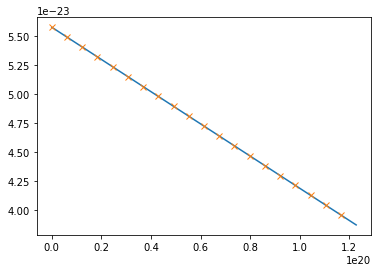

In [82]:
import matplotlib.pyplot as plt

x = np.linspace(0, ds, num=10000)
plt.plot(x, f(x, e, de, k, dk)) ;

i1,i2 = (f(0, e, de, k, dk), f(ds, e, de, k, dk))

m = (i2-i1)/ds

plt.plot(x[::500], x[::500]*m+i1, ls='', marker='x') ;

In [76]:
x[::2]

array([0.00000000e+00, 2.45546949e+16, 4.91093898e+16, ...,
       1.22699810e+20, 1.22724365e+20, 1.22748920e+20])

In [47]:
np.exp(-k**2/2/dk)

1.1247686222284667

In [44]:
ds

1.2276119715538785e+20

## Sightline determination

It is unreasonable to expect one to evaluate the entire intensity map if there are just a handful of sightlines that are flagged as erroneous. For that reason, one can use the following cells to identify which sightline(s) the intensity is not calculated correctly.

In [1]:
from pprint import pprint

import numpy as np
from astropy.io import fits

In [16]:
chmap = fits.open(r"/media/4,0 TB Hard Disk/yanitski/projects/pdr/KT3_history/MilkyWay/r400_cm1.0-1.0_d1.0_uv10/channel_intensity.fits")

In [17]:
chmap[1].shape

(701, 3, 360, 17)

In [18]:
pprint(chmap[1].header)

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    4 / number of array dimensions                     
NAXIS1  =                   17                                                  
NAXIS2  =                  360                                                  
NAXIS3  =                    3                                                  
NAXIS4  =                  701                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
TYPE    = 'Species transitions'                                                 
BUNIT   = 'K       '                                                            
CTYPE1  = 'Wavelength'                                                          
CUNIT1  = 'm       '        

In [20]:
chmap[1].data[:, :, :, 0].min()

-5.868130065198171

In [23]:
np.where(chmap[1].data[:,:,180,0]<0)

(array([617, 617, 617]), array([0, 1, 2]))

In [9]:
vel = np.linspace(chmap[1].header['CRVAL1'] - chmap[1].header['CDELT1']*chmap[1].header['CRPIX1'],
                  chmap[1].header['CRVAL1'] + chmap[1].header['CDELT1']*chmap[1].header['CRPIX1'],
                  num=chmap[1].header['NAXIS1'])
lon = np.linspace(chmap[1].header['CRVAL2'] - chmap[1].header['CDELT2']*chmap[1].header['CRPIX2'],
                  chmap[1].header['CRVAL2'] + chmap[1].header['CDELT2']*chmap[1].header['CRPIX2'],
                  num=chmap[1].header['NAXIS2'])

In [11]:
lon[170],lon[173]

(2.8414642208742613, 2.9473572974285815)

Below I copy the portion of `kosmatau3d` that selects the voxels in an sightline. I will use this to focus on the *glitches* in the PV diagram.

In [ ]:
eps_sp = fits.open('/media/4,0 TB Hard Disk/yanitski/projects/pdr/KT3_history/MilkyWay/r400_cm1.0-1.0_d1.0_uv10/species_emissivity.fits')[0].data
kap_sp = fits.open('/media/4,0 TB Hard Disk/yanitski/projects/pdr/KT3_history/MilkyWay/r400_cm1.0-1.0_d1.0_uv10/species_absorption.fits')[0].data
eps_d = fits.open('/media/4,0 TB Hard Disk/yanitski/projects/pdr/KT3_history/MilkyWay/r400_cm1.0-1.0_d1.0_uv10/dust_emissivity.fits')[0].data
kap_d = fits.open('/media/4,0 TB Hard Disk/yanitski/projects/pdr/KT3_history/MilkyWay/r400_cm1.0-1.0_d1.0_uv10/dust_absorption.fits')[0].data
xGrid,yGrid,zGrid = (fits.open('/media/4,0 TB Hard Disk/yanitski/projects/pdr/KT3_history/MilkyWay/r400_cm1.0-1.0_d1.0_uv10/voxel_position.fits')[0].data[:, 0],
                     fits.open('/media/4,0 TB Hard Disk/yanitski/projects/pdr/KT3_history/MilkyWay/r400_cm1.0-1.0_d1.0_uv10/voxel_position.fits')[0].data[:, 1],
                     fits.open('/media/4,0 TB Hard Disk/yanitski/projects/pdr/KT3_history/MilkyWay/r400_cm1.0-1.0_d1.0_uv10/voxel_position.fits')[0].data[:, 2])

radGrid = np.sqrt((xGrid-constants.rGalEarth)**2 + yGrid**2 + zGrid**2)
lonGrid = np.arctan2(yGrid, -(xGrid-constants.rGalEarth))
if lon < 0:
    lonGrid[lonGrid > 0] = lonGrid[lonGrid > 0] - 2*np.pi
if lon > 0:
    lonGrid[lonGrid < 0] = lonGrid[lonGrid < 0] + 2*np.pi
rPolar = np.sqrt((xGrid-constants.rGalEarth)**2+yGrid**2)
latGrid = np.arctan2(zGrid, rPolar)
if lat < 0:
    latGrid[latGrid > 0] = latGrid[latGrid > 0] - np.pi
if lat > 0:
    latGrid[latGrid < 0] = latGrid[latGrid < 0] + np.pi
scaling = np.sqrt(2)  # 2#
width = scaling*constants.voxel_size*np.max([np.sin(np.abs(lonGrid-np.pi/4)),
                                             np.sin(np.abs(lonGrid+np.pi/4))], axis=0)
height = scaling*constants.voxel_size*np.max([np.sin(np.abs(latGrid-np.pi/4)),
                                              np.sin(np.abs(latGrid+np.pi/4))], axis=0)
d_lon = 0.5*np.arctan(width/radGrid)
d_lon[(lat > 1.0) | (lat < -1.0)] = np.pi
d_lat = 0.5*np.arctan(height/radGrid)
d_lat[(lat > 1.0) | (lat < -1.0)] = np.pi/2.
# iLoS = np.where((abs(lonGrid-x1LoS)<=dLon)&(abs(latGrid-x2LoS)<=dLat)&rt.i_vox)[0]
i_los = np.where((abs(lonGrid-x1LoS) <= d_lon) & (abs(latGrid-x2LoS) <= d_lat))[0]
i_los_ordered = i_los[np.argsort(radGrid[i_los])[::-1]]

e_sp = eps_sp[i_los_ordered, 617, :] / 3.086/10**18
de_sp = 
k_sp = kap_sp[i_los_ordered, 617, :] / 3.086/10**18
dk_sp = 
e_d = eps_d[i_los_ordered, 617, :] / 3.086/10**18
de_d = 
k_d = kap_d[i_los_ordered, 617, :] / 3.086/10**18
dk_d = 